<a href="https://colab.research.google.com/github/parkmicheal1114/study/blob/main/%EC%9E%90%EC%A0%84%EA%B1%B0%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 개요 
 -  https://www.kaggle.com/competitions/bike-sharing-demand/overview
 -  대회 참가자는 워싱턴 DC의 Captal BikeShare 프로그램에서 과거 사용 패턴과 날씨 데이터를 결합해야 한다고 한다.
 - 이번 실습의 목표는 단순히 여러 회귀를 구현하고 익히기 위함이라서 위의 데이터 결합은 추후에 시도 한다.
 - 이번 실습은 파이썬 머신 러닝 가이드에 따른다.

# 데이터 설명
 
1. 데이터 경로
 - https://www.kaggle.com/competitions/bike-sharing-demand/data?select=train.csv
 
2. 변수 
 - datetime - hourly date + timestamp  
 - season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
 - holiday - 해당 요일을 휴일
 - workingday - whether the day is neither a weekend nor holiday
 - weather  
    1: 맑음, 약간 구름, 부분 흐림, 부분 흐림
    
    2: 안개 + 흐림, 안개 + 부서진 구름, 안개 + 약간 구름, 안개
    
    3: 가벼운 눈, 약한 비 + 뇌우 + 흩어진 구름, 약한 비 + 흩어진 구름
    
    4: 폭우 + 얼음 팔레트 + 뇌우 + 안개, 눈 + 안개

 - temp - temperature in Celsius
 - atemp - "feels like" temperature in Celsius ( 체감온도 )
 - humidity - relative humidity ( 습도 ) 
 - windspeed - wind speed ( 풍속 )
 - casual - number of non-registered user rentals initiated ( 미예약 대여 초기값 )
 - registered - number of registered user rentals initiated ( 예약 대여 초기값 )
 - count - number of total rentals

# 데이터 확인.

In [1]:
from io import IncrementalNewlineDecoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

%matplotlib Inline


df_bike = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/study_dataset/bike_share/train.csv')
df_bike.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [3]:
df_bike.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

 - 10886 x rows , 12 x columns 
 - 결측치는 관측 되지 않음.
 - 대여 수를 예측 하고자 하는 것이기 때문에 counts 종속 변수가 됨.
 - datetime 은 date형 으로 자료 변환 후 진행.

# 데이터 클렌징 및 가공과 데이터 시각화

1. datetime

In [4]:
# datatime 컬럼 data type 변환
df_bike.datetime = pd.to_datetime(df_bike.datetime)

# datatime 에서 년,월,일,시간 추출
df_bike['Year'] = df_bike['datetime'].dt.year
df_bike['Month'] = df_bike['datetime'].dt.month
df_bike['Day'] = df_bike['datetime'].dt.day
df_bike['Hour'] = df_bike['datetime'].dt.hour
df_bike.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,Year,Month,Day,Hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [5]:
# datetime 과 casual , resgistered 제거
# datetime 은 분해 되었음
# casual + resgistered = count 라서 count 하나만 사용 하겠음.

df_bike.drop(['datetime','registered','casual'],axis =1 , inplace=True)

In [6]:
df_bike.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

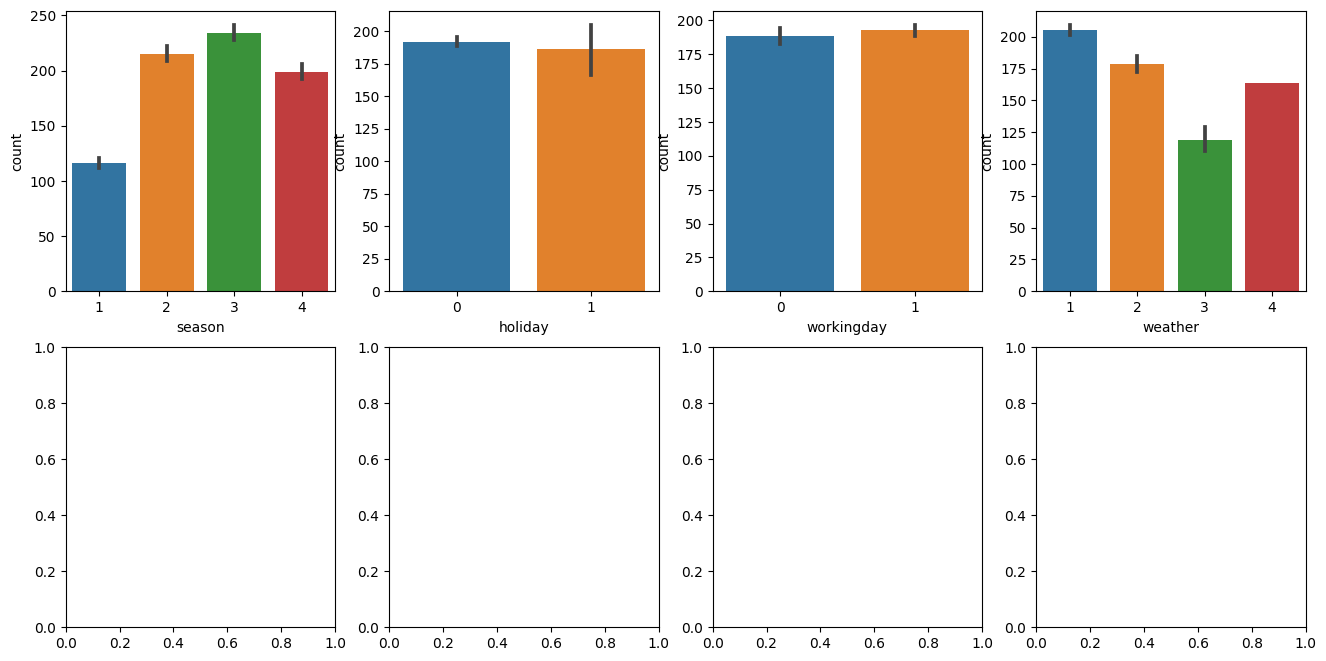

In [7]:
# count 분포 시각화 (#1)
fig , axs  = plt.subplots(figsize=(16,8) , ncols= 4, nrows = 2)
features = ['season', 'holiday', 'workingday', 'weather']

for i , feature in enumerate(features):
  row = int(i/4)
  col = i%4
  sns.barplot(x=feature , y='count', data = df_bike , ax = axs[row][col])

 - season : 여름 / 가을에 대여가 많은 것을 알 수 있다. 
 - holoyday , working day 에서 휴일 보다는 주중에 더 대여 수가 조금 늘어 남 을 알수 있다.
 - 날씨는  1 - 2 - 4  - 3 순으로 상식적로 생각 했던 것 처럼 날씨가 좋은 경우에 대여 수가 많다는 것은 알 수 있었다. 다만 날씨가 제일 안 좋았던 4번의 경우가 3번의 경우보다 대여가 많다는 것과 2번의 경우와 대비 해 봐도 차이가 크지 않다는 점은 눈여겨 볼만 하다.

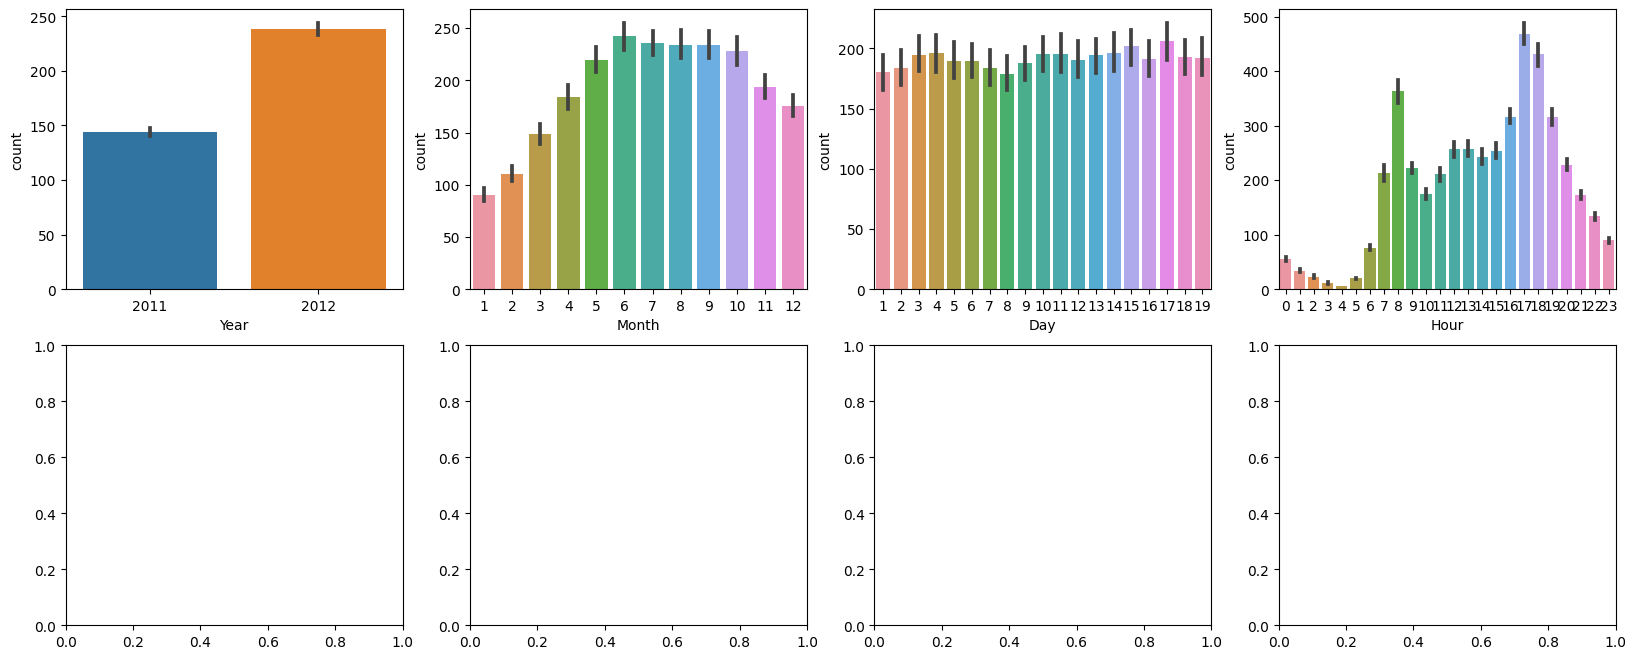

In [8]:
# count 분포 시각화 (#2 - 날짜 )
fig , axs  = plt.subplots(figsize=(20,8) , ncols= 4, nrows = 2)
features = ['Year', 'Month', 'Day', 'Hour']

for i , feature in enumerate(features):
  row = 0
  col = i%4
  sns.barplot(x=feature , y='count', data = df_bike , ax = axs[row][col])

 - 2011 대비해서 2012 년 대여 수가 증가. 
 - 계절에 따른 대여수의 차이에서 알수 있듯이 여름/가을에 해당하는 month 에 대여수가 늘어 난다. 
 - Day 는 크게 무관한듯 하다.
 - Hour 는 생각 했던 것 처럼 07~20시에 많이 몰려 있으며 , 제일 대여가 많은 시간은 17시 , 제일 대여가 적은 시간은 04:00 이다. 주로 출/퇴근 시간의 대여수가 많음을 알 수 있다.

# 회귀 모델 적용

 - RMSE , RMSLE , MSE 평가 함수

In [9]:
from sklearn.metrics import mean_squared_error , mean_absolute_error

# log 값 변환시 NaN(언더플로 혹은 오버플로)이슈로 인하여 log 가 아닌 log1p() 를 이용해서 RMSLE 계산
def rmsle(y,pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y-log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

# mean_sqaure_erroe 계산
def rmse(y,pred):
  return np.sqrt(mean_squared_error(y,pred))

# MAE,RMSE,RMLE 를 모두 계산 
def evaluate_regar(y,pred):
  rmsle_val = rmsle(y,pred)
  rmse_val = rmse(y,pred)
  # MAE 
  mae_val = mean_absolute_error(y,pred)
  print(f'RMSLE : {rmsle_val:.3f} , RMSE : {rmse_val:.3f} , MAE : {mae_val: .3f}')


- 회귀 모델 적용 (전처리 전)

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

# target , feature 분리 
target = df_bike['count']
feature = df_bike.drop(['count'],axis = 1)

# 학습셋 , 테스트셋 분리 ( 7:3 )
X_train , X_test , y_train , y_test = train_test_split ( feature , target , test_size= 0.3 , random_state=1114)

# LinearRegression 모델 적용
model_lr = LinearRegression()
model_lr.fit(X_train , y_train)
# 예측값
pred_lr = model_lr.predict(X_test)

# 검증값
evaluate_regar(y_test , pred_lr)


RMSLE : 1.200 , RMSE : 142.176 , MAE :  106.735


In [11]:
# 실제 값과 예측값이 어느 정도 차이가 나는지 비교.

def top5_error_data(y_test,pred , n_top=5):
  df_result = pd.DataFrame(y_test.values , columns = ['real'])
  df_result['predict'] = np.round(pred)
  df_result['diff'] = np.abs(df_result.real - df_result.predict)
  # 예측값과 실제 값이 큰 데이터 순으로 출력
  print(df_result.sort_values('diff',ascending = False)[:n_top])

top5_error_data(y_test , pred_lr , n_top = 5)

      real  predict   diff
66     834    185.0  649.0
2277   839    200.0  639.0
1598   809    196.0  613.0
1889   948    359.0  589.0
461    917    339.0  578.0


- 회귀에서 이렇게 큰 예측 오류가 발생 하는 경우 가장 먼저 살펴 볼 것은 Target 의 분포를 살펴 보자. target 의 분포는 정규 분포가 좋다 .
- log1p 를 적용한 경우 를 확인 해 보자 

In [12]:
#  타깃 컬럼인 count 를 log1p로 로그 변환.
target_log = np.log1p(target)

# 로그 변환 반영하여 학습/테스트 데이터 셋 분리
X_train , X_test , y_train , y_test = train_test_split ( feature , target_log , test_size= 0.3 , random_state=1114)

# LinearRegression 모델 적용
model_lr = LinearRegression()
model_lr.fit(X_train , y_train)
# 예측값
pred_lr = model_lr.predict(X_test)

# 테스트 데이터 세트의 target 값은 로그 변환 하였으므로 , 다시 expm1 을 이용해 원래 스케일로 변환 (테스트셋)
y_test_exp = np.expm1(y_test)

# 테스트 데이터 세트의 target 값은 로그 변환 하였으므로 , 다시 expm1 을 이용해 원래 스케일로 변환 (예측값)
pred_exp = np.expm1(pred_lr)

# 검증값
evaluate_regar(y_test_exp , pred_exp)


RMSLE : 1.013 , RMSE : 159.704 , MAE :  107.087


- scaling을 하기 전과 크게 향상 된 느낌은 아니다.
- 그래서 개별 피처들의 인코딩을 적용 해 보기로 하며 , 각 피처의 회귀 계수 값은 시각화 해서 살펴 보자 .

<Axes: >

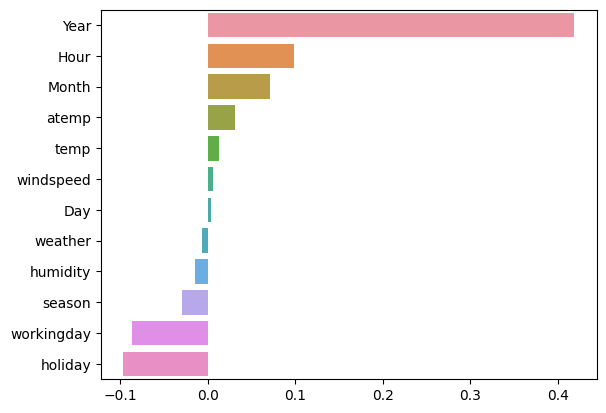

In [13]:
# 회귀 계수 시각화
coef = pd.Series(model_lr.coef_ , index = feature.columns)
sort_coef = coef.sort_values(ascending=False) 
sns.barplot(x=sort_coef.values , y = sort_coef.index)

 - year , hour , month 등의 회귀 계수가 상대 적으 높은 것으로 보이는데 명목형 변수 이기 때문라서 이런 영향력은 옳지 않은 것으로 보인다. 
 - 이 변수들을 단순한 값이 아닌 , 원-핫 인코딩을 통해서 명목형으로 변환 해야 한다.

In [14]:
# 명목형 변수들에 대한 원-핫 인코딩 
# feature_cat = ['season', 'holiday', 'workingday', 'weather', 'Year', 'Month', 'Day', 'Hour']
feature_ohe = pd.get_dummies(feature, columns = ['season', 'holiday', 'workingday', 'weather', 'Year', 'Month', 'Day', 'Hour'])
feature_ohe.head(5)

,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,9.84,14.395,81,0.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,9.02,13.635,80,0.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,9.02,13.635,80,0.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,9.84,14.395,75,0.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,9.84,14.395,75,0.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
feature_ohe.columns

Index(['temp', 'atemp', 'humidity', 'windspeed', 'season_1', 'season_2',
       'season_3', 'season_4', 'holiday_0', 'holiday_1', 'workingday_0',
       'workingday_1', 'weather_1', 'weather_2', 'weather_3', 'weather_4',
       'Year_2011', 'Year_2012', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10',
       'Month_11', 'Month_12', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5',
       'Day_6', 'Day_7', 'Day_8', 'Day_9', 'Day_10', 'Day_11', 'Day_12',
       'Day_13', 'Day_14', 'Day_15', 'Day_16', 'Day_17', 'Day_18', 'Day_19',
       'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6',
       'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12',
       'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18',
       'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23'],
      dtype='object')

## 회귀 모델 적용 (Linear , Lasso , Ridge , ElasticNET )
 - 명목형 : 원핫 인코딩 ( feature_ohe )
 - 타겟 : log1P ( target_log )

In [16]:
# 인코딩 적용된 피처 데이터 세트 기반으로 학습 / 예측 데이터 분할
X_train , X_test , y_train , y_test = train_test_split ( feature_ohe , target_log , test_size= 0.3 , random_state=1114)

# 모델과 학습 데이터 세트를 입력 하면 성능 평가 수치를 반환 
def get_model_predict(model , X_train , X_test , y_train , y_test , is_expm1= False):
  model.fit(X_train , y_train)
  pred = model.predict(X_test)
  if is_expm1:
    y_test_expm = np.expm1(y_test)
    pred_expm = np.expm1(pred)
  print(f'### {model.__class__.__name__} ###')
  evaluate_regar(y_test_expm , pred_expm)

from sklearn.linear_model import LinearRegression , Lasso , Ridge , ElasticNet

# 모델 별로 평가 수행
model_lr = LinearRegression()
model_lasso = Lasso(alpha = 0.01)
model_ridge = Ridge(alpha = 10)
model_en = ElasticNet(alpha = 0.01 , l1_ratio = 0.3 )

for model in [model_lr , model_lasso , model_ridge , model_en]:
  get_model_predict(model, X_train ,X_test , y_train , y_test , is_expm1=True)



### LinearRegression ###
RMSLE : 0.581 , RMSE : 94.708 , MAE :  61.493
### Lasso ###
RMSLE : 0.632 , RMSE : 111.847 , MAE :  71.715
### Ridge ###
RMSLE : 0.582 , RMSE : 95.928 , MAE :  62.182
### ElasticNet ###
RMSLE : 0.632 , RMSE : 107.742 , MAE :  68.570


 - 인코딩을 적용후에 예측 성능이 많이 향상 됨.

<Axes: >

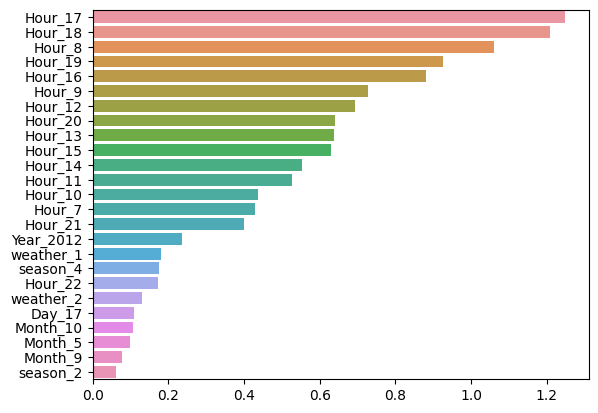

In [17]:
# 회귀 계수 시각화
coef = pd.Series(model_ridge.coef_ , index = feature_ohe.columns)
sort_coef = coef.sort_values(ascending=False)[:25]
sns.barplot(x=sort_coef.values , y = sort_coef.index)

 - Year 의 영향력이 여전히 있지만 , 계절이나 , 날씨 등의 변수 들이 인코딩 전보다 회귀식에 영향력을 미치고 있다. 

# 트리 계열 회귀

In [18]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 모델 별로 평가 수행
model_rf = RandomForestRegressor(n_estimators = 500)
model_gbm = GradientBoostingRegressor(n_estimators = 500)
model_xgb = XGBRegressor(n_estimators = 500)
model_lgbm = LGBMRegressor(n_estimators = 500)

# 앞서 선형회귀에서 생성했던 get_model_predcit 를 사용
for model in [model_rf , model_gbm , model_xgb , model_lgbm]:
  get_model_predict(model, X_train ,X_test , y_train , y_test , is_expm1=True)

### RandomForestRegressor ###
RMSLE : 0.345 , RMSE : 48.426 , MAE :  29.886
### GradientBoostingRegressor ###
RMSLE : 0.328 , RMSE : 52.096 , MAE :  32.359
### XGBRegressor ###
RMSLE : 0.334 , RMSE : 52.650 , MAE :  30.248
### LGBMRegressor ###
RMSLE : 0.304 , RMSE : 45.621 , MAE :  27.447


<Axes: >

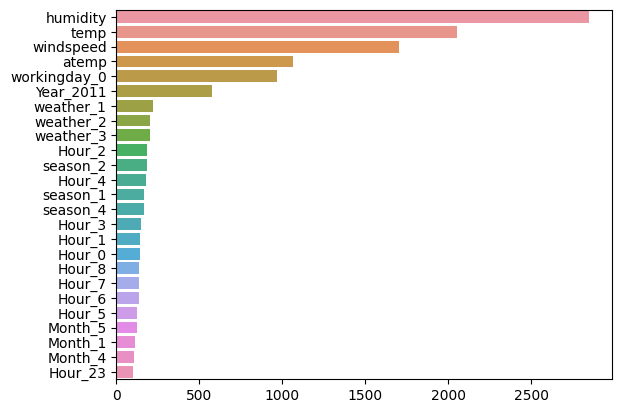

In [19]:
# feature 중요도 시각화 ( LGBM )
# 트리 계열은호귀 계수가 아닌 , feature_importance_ 를 사용.
coef = pd.Series(model_lgbm.feature_importances_ , index = feature_ohe.columns)
sort_coef = coef.sort_values(ascending=False)[:25]
sns.barplot(x=sort_coef.values , y = sort_coef.index)

- 데이터셋의 영향이라고 하는데 , 조금 더 학습이 필요한 내용일 것 같다. (선형 이 비해서 트리계열의 정확도가 조금더 좋게 나온 결과에 대해서 )
- LGBM 이 제일 평가 점수가 잘 나왔고 , 이를 토대로 하이퍼 파라미터 최적화 와 교차 검증을 진행 한다.

# LGBM 하이퍼파라미터 최적화 ,

In [20]:
from sklearn.model_selection import GridSearchCV

model_lgbm = LGBMRegressor()

# 파라미터 설정
params = {'n_estimators':[100 ,300] , 'learning_rate':[0.1, 0.01, 0.05],'max_depth':[5,7],'boosting_type':['gbdt'] , 'objective':['regression']}

# grid 적용
grid = GridSearchCV(model,param_grid=params , cv=3 , refit=True )
grid.fit(X_train,y_train)

# GridCV 결과를 추출해서 df 로 변환
score_df = pd.DataFrame(grid.cv_results_)
score_df[['params','mean_test_score','rank_test_score','split0_test_score','split1_test_score']]
score_df
# grid.best_estimator_
# early_stopping_rounds=50


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,param_learning_rate,param_max_depth,param_n_estimators,param_objective,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.088285,0.009573,0.011617,0.000182,gbdt,0.1,5,100,regression,"{'boosting_type': 'gbdt', 'learning_rate': 0.1...",0.920984,0.909900,0.920007,0.916964,0.005010,6
1,0.250649,0.082502,0.032853,0.005420,gbdt,0.1,5,300,regression,"{'boosting_type': 'gbdt', 'learning_rate': 0.1...",0.943586,0.936073,0.943515,0.941058,0.003525,2
2,0.113712,0.013624,0.013943,0.000186,gbdt,0.1,7,100,regression,"{'boosting_type': 'gbdt', 'learning_rate': 0.1...",0.937512,0.927603,0.936674,0.933930,0.004487,4
3,0.258282,0.009886,0.038322,0.001670,gbdt,0.1,7,300,regression,"{'boosting_type': 'gbdt', 'learning_rate': 0.1...",0.944581,0.939936,0.946174,0.943564,0.002646,1
4,0.092187,0.013624,0.011067,0.000192,gbdt,0.01,5,100,regression,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",0.576601,0.542765,0.558293,0.559220,0.013829,12
5,0.210818,0.007229,0.026036,0.000338,gbdt,0.01,5,300,regression,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",0.823399,0.801702,0.809458,0.811520,0.008977,10
6,0.521792,0.210582,0.026600,0.005281,gbdt,0.01,7,100,regression,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",0.662495,0.634529,0.645664,0.647563,0.011496,11
7,0.818701,0.787164,0.032001,0.000396,gbdt,0.01,7,300,regression,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",0.867670,0.847083,0.857244,0.857332,0.008405,9
8,0.093109,0.007163,0.011702,0.000156,gbdt,0.05,5,100,regression,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",0.882308,0.866810,0.878093,0.875737,0.006543,8
9,0.200526,0.002979,0.028473,0.001620,gbdt,0.05,5,300,regression,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",0.935389,0.925097,0.929756,0.930081,0.004208,5


In [38]:
grid.best_params_

model_lgbm=LGBMRegressor(learning_rate=0.1,max_depth=7,n_estimators=500)
#  튜닝된 베스트 파라미터
# model_lgbm=LGBMRegressor(grid.best_estimator_)
get_model_predict(model_lgbm, X_train ,X_test , y_train , y_test , is_expm1=True)

### LGBMRegressor ###
RMSLE : 0.304 , RMSE : 44.431 , MAE :  27.274


In [39]:
# 실제 값과 예측값이 어느 정도 차이가 나는지 비교.
pred = model_lgbm.predict(X_test)

# 테스트 데이터 세트의 target 값은 로그 변환 하였으므로 , 다시 expm1 을 이용해 원래 스케일로 변환 (테스트셋)
y_test_exp = np.expm1(y_test)

# 테스트 데이터 세트의 target 값은 로그 변환 하였으므로 , 다시 expm1 을 이용해 원래 스케일로 변환 (예측값)
pred_exp = np.expm1(pred)

def top5_error_data(y_test,pred , n_top=5):
  df_result = pd.DataFrame(y_test.values , columns = ['real'])
  df_result['predict'] = np.round(pred)
  df_result['diff'] = np.abs(df_result.real - df_result.predict)
  # 예측값과 실제 값이 큰 데이터 순으로 출력
  print(df_result.sort_values('diff',ascending = False)[:n_top])

top5_error_data(y_test_exp ,pred_exp , n_top = 1000)

       real  predict   diff
2049  425.0    790.0  365.0
2972  601.0    952.0  351.0
2362  743.0    400.0  343.0
1047  687.0    377.0  310.0
1004  233.0    539.0  306.0
...     ...      ...    ...
415   109.0    139.0   30.0
2316  117.0    147.0   30.0
21    296.0    326.0   30.0
2676  511.0    481.0   30.0
1043  161.0    131.0   30.0

[1000 rows x 3 columns]


# 정리
 - LGBM 하이퍼파라미터 튜팅을 시도 했지만 만족할 만한 결과 인지는 모르겠다. 아직 결과를 보고 적용하는 것은 학습이 필요로 할 듯 하다.
 - 추후 유즈 케이스 등을 보고 다시 시도 하도록 한다.